In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../') # you should not need to uncomment this!
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [26]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from poutyne import Model, SKLearnMetrics
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, median_absolute_error
from mlflood.dataset import load_dataset, load_test_dataset, dataloader_tr_val, dataloader_test
from mlflood.dataset import load_dataset, load_test_dataset
from mlflood.models.CNN_base import CNN_base
from mlflood.models.Baseline import Baseline
from torchsummary import summary
from mlflood.loss import l1_loss_weight, l2_loss, l1_loss
from mlflood.evaluation import mses2plot, mse, predict_dataset, predict_batch
import numpy as np
import datetime
import time
import copy
from torch.utils.tensorboard import SummaryWriter
from mlflood.evaluation import predict_batch, predict_event, mae_event
from mlflood.evaluation import plot_maes, multiboxplot, plot_answer_sample, boxplot_mae, mat2movie, numpy2movie
from mlflood.training import training_loop

In [17]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
catchment_num = "toy"
model_name = "test"
border_size = 0
timestep = 1
normalize_output = False
use_diff_dem = False

# parameter for the catchment
catchment_kwargs = {}
catchment_kwargs["tau"]=0.5
catchment_kwargs["timestep"]= timestep            # for timestep >1 use CNN rolling or Unet
catchment_kwargs["sample_type"]="full"
catchment_kwargs["dim_patch"]=60
catchment_kwargs["fix_indexes"]=False
catchment_kwargs["use_diff_dem"] = use_diff_dem
catchment_kwargs["border_size"] = border_size

# opti# optimization paramters
optimization_kwargs = {}
optimization_kwargs["batch_size"] = 4
optimization_kwargs["epochs"] = 2
optimization_kwargs["learning_rate"] = 0.0001
optimization_kwargs["weight_d"] = 0.0001 
        
date = datetime.datetime.now().strftime("%Y%m%d")
# date = #"%Y%m%d"
experiment_name = f"{date}-{catchment_num}-{model_name}-{border_size}-{timestep}-{normalize_output}"

#path_loc = "/scratch2/dl_repo/physical_ml/sims/" + experiment_name
path_loc = experiment_name

In [6]:
model = CNN_base(border_size=border_size, timestep = timestep, use_diff_dem=use_diff_dem)
model = model.to(device)

In [7]:
train_dataset, valid_dataset = load_dataset(catchment_num=catchment_num, **catchment_kwargs)
dataloaders_train, dataloaders_valid = dataloader_tr_val(train_dataset, valid_dataset, catchment_num = catchment_num, batch_size = 8)

Load file: /home/tdonauer/tabea_mt/data/generated_datasets/toy-train.h5
Load file: /home/tdonauer/tabea_mt/data/generated_datasets/toy-val.h5


In [8]:
# local_batch = next(iter(dataloaders_train))
# local_x = local_batch['x'].to(device) 
# local_y = local_batch['y'].to(device) 
# local_mask = local_batch['mask'].to(device) 
# predictions = model(local_x, local_mask)

Epoch: 1 , train loss: 0.06559 , val loss: 0.04812
Training complete in 0m 44s


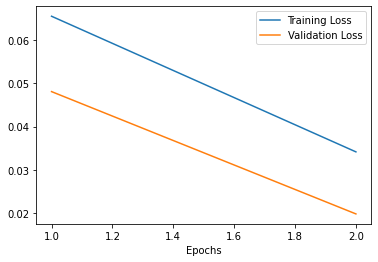

In [9]:
model, history = training_loop(model, l1_loss, dataloaders_train, dataloaders_valid, optimization_kwargs, device, path_loc)

ep = np.arange(1, optimization_kwargs["epochs"]+1)
train_loss = history['train_loss']
val_loss = history['val_loss']
plt.plot(ep, train_loss, label="Training Loss")
plt.plot(ep, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.legend()

### Mse for CNN

In [19]:
dataset = valid_dataset

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


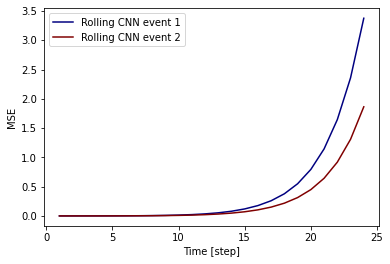

In [20]:
from mlflood.evaluation import predict_dataset, mse_from_predicted_dataset

predictions_ag = predict_dataset(model, dataset)

timestep = catchment_kwargs["timestep"]

mse_roll = mse_from_predicted_dataset(predictions_ag)
for event_n in range(len(predictions_ag)):
    mse_roll[event_n] = np.insert(mse_roll[event_n], 0, [0]*(timestep-1))

t = np.arange(1,len(dataset.rainfall_events[0]))

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 2,2))))
plt.plot(t, mse_roll[0].T, "-", label="Rolling CNN event 1")
plt.plot(t, mse_roll[1].T, "-", label="Rolling CNN event 2")

plt.xlabel("Time [step]")
plt.ylabel("MSE")
plt.legend()

### MSE for comparing 1 step prediction of current model with baseline 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]


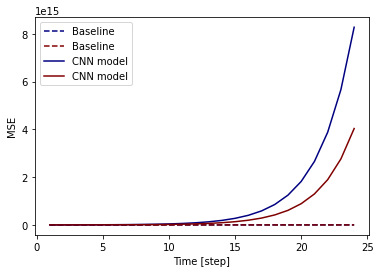

In [29]:
from mlflood.evaluation import predict_dataset, mse_from_predicted_dataset

dataset = valid_dataset

predictions_ag = predict_dataset(Baseline(), dataset)
base_mse = mse_from_predicted_dataset(predictions_ag)
for event_n in range(len(predictions_ag)):
    base_mse[event_n] = np.insert(base_mse[event_n], 0, [0]*(timestep-1))
base_mse = np.array(base_mse)


predictions_ag = predict_dataset(model, dataset)
mse = mse_from_predicted_dataset(predictions_ag)
for event_n in range(len(predictions_ag)):
    mse[event_n] = np.insert(mse[event_n], 0, [0]*(timestep-1))
mse = np.array(mse)
    

t = np.arange(1,len(dataset.rainfall_events[0]))

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 2,2))))
plt.plot(t, base_mse.T, "--", label="Baseline")
plt.plot(t, mse.T, "-", label="CNN model")

plt.xlabel("Time [step]")
plt.ylabel("MSE")
plt.legend()

### Mse only in Autoregressive mode (timestep=1)

In [25]:
from mlflood.evaluation import pred_ag, mse_from_predicted_dataset, base_model

predictions_ag = pred_ag(base_model(), dataset)
base_mse = np.array(mse_from_predicted_dataset(predictions_ag))

predictions_ag = pred_ag(model, dataset)
mse = np.array(mse_from_predicted_dataset(predictions_ag))

t = np.arange(dataset.timestep,len(dataset.rainfall_events[0]))

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 2,2))))
plt.plot(t, base_mse.T, "--", label="Baseline")
plt.plot(t, mse.T, "-", label="Base CNN")

plt.xlabel("Time [step]")
plt.ylabel("MSE")
plt.legend()



ImportError: cannot import name 'pred_ag' from 'mlflood.evaluation' (/home/tdonauer/tabea_mt/mlflood/evaluation.py)

### Display current model result

In [ ]:
from mlflood.evaluation import numpy2movie
predictions_ag = predict_dataset(model, dataset)               # use pred_ag for prediction in autoregressive model

animation = numpy2movie(*predictions_ag[0])
animation.ipython_display(fps=10, loop=True, autoplay=True)